# 015. word2vec 작성

- skipgram, window size 2 의 simplified word2vec model 작성

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
import numpy as np
import re

### Toy 말뭉치

In [2]:
corpus = ['king is a very strong man',
          'queen is a wise and pretty woman',
          'boy is a young man',
          'girl is a young and pretty woman',
          'prince is young and will be a strong and wise king',
          'princess is a young woman and will be a pretty and wise queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be a king',
          'princess is a girl will be a queen']

# corpus = ['왕은 매우 강한 남자이다',
#           '여왕은 현명한 예쁜 여자이다',
#           '소년은 젊은 남자이다',
#           '소녀는 젊은 예쁜 여자이다',
#           '왕자는 젊고 현명한 왕이 될 것이다',
#           '공주는 젊고 예쁜 현명한 여왕이 될 것이다',
#           '남자는 강하다',
#           '여자는 예쁘다',
#           '왕자는 왕이 될 소년이다',
#           '공주는 왕비가 될 소녀이다']

In [3]:
cleaned_corpus = []
for text in corpus:
    print(text)
    text = re.sub(r'[^a-zA-Z]', '', text)  #영문
    #text = re.sub(r'[^a가-힣]', '', text)  #한글
    cleaned_corpus.append(text.lower())

king is a very strong man
queen is a wise and pretty woman
boy is a young man
girl is a young and pretty woman
prince is young and will be a strong and wise king
princess is a young woman and will be a pretty and wise queen
man is strong
woman is pretty
prince is a boy will be a king
princess is a girl will be a queen


### stopword 제거

In [4]:
# from konlpy.tag import Okt
# okt = Okt()
# okt.morphs

In [5]:
stop_words = ['is', 'a' ,'will', 'be', 'and']
#stop_words = ['은', '가', '이다', '는', '이', '될']

results = []

for text in corpus:
    tmp = []
    #for word in okt.morphs(text):
    for word in text.split():
        if word not in stop_words:
            tmp.append(word)
    results.append(' '.join(tmp))

In [6]:
cleaned_corpus = results
cleaned_corpus

['king very strong man',
 'queen wise pretty woman',
 'boy young man',
 'girl young pretty woman',
 'prince young strong wise king',
 'princess young woman pretty wise queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

### vocaburary 모음 작성

In [7]:
words = []

for sentence in corpus:
    for word in sentence.split(' '):
        words.append(word)

words = list(set(words))
words

['will',
 'king',
 'very',
 'queen',
 'woman',
 'pretty',
 'young',
 'be',
 'man',
 'a',
 'and',
 'is',
 'boy',
 'strong',
 'girl',
 'prince',
 'wise',
 'princess']

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [8]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [9]:
word2index

{'will': 0,
 'king': 1,
 'very': 2,
 'queen': 3,
 'woman': 4,
 'pretty': 5,
 'young': 6,
 'be': 7,
 'man': 8,
 'a': 9,
 'and': 10,
 'is': 11,
 'boy': 12,
 'strong': 13,
 'girl': 14,
 'prince': 15,
 'wise': 16,
 'princess': 17}

### skip-gram 으로 training data 생성

In [10]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences

[['king', 'is', 'a', 'very', 'strong', 'man'],
 ['queen', 'is', 'a', 'wise', 'and', 'pretty', 'woman'],
 ['boy', 'is', 'a', 'young', 'man'],
 ['girl', 'is', 'a', 'young', 'and', 'pretty', 'woman'],
 ['prince',
  'is',
  'young',
  'and',
  'will',
  'be',
  'a',
  'strong',
  'and',
  'wise',
  'king'],
 ['princess',
  'is',
  'a',
  'young',
  'woman',
  'and',
  'will',
  'be',
  'a',
  'pretty',
  'and',
  'wise',
  'queen'],
 ['man', 'is', 'strong'],
 ['woman', 'is', 'pretty'],
 ['prince', 'is', 'a', 'boy', 'will', 'be', 'a', 'king'],
 ['princess', 'is', 'a', 'girl', 'will', 'be', 'a', 'queen']]

In [11]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [12]:
data[:10]

[['king', 'is'],
 ['king', 'a'],
 ['is', 'king'],
 ['is', 'a'],
 ['is', 'very'],
 ['a', 'king'],
 ['a', 'is'],
 ['a', 'very'],
 ['a', 'strong'],
 ['very', 'is']]

In [13]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,king,is
1,king,a
2,is,king
3,is,a
4,is,very


### One hot encoding

In [14]:
from tensorflow.keras.utils import to_categorical

len(words)

18

### One hot encoding 된 train, label data

In [15]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [16]:
print(X[:3])
print(Y[:3])

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.])]
[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.])]


In [17]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [18]:
model = Sequential()
model.add(Input(shape=(len(words),)))
model.add(Dense(2))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(X_train, Y_train, epochs=500, batch_size=3)

Epoch 1/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0718 - loss: 7.0413
Epoch 2/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0688 - loss: 10.2294
Epoch 3/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0605 - loss: 9.7075
Epoch 4/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0944 - loss: 10.1137
Epoch 5/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0681 - loss: 9.4868
Epoch 6/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0372 - loss: 9.5863
Epoch 7/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0973 - loss: 9.7408
Epoch 8/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0645 - loss: 9.5647
Epoch 9/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0803 - loss: 10.1315
Epoch 10/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0596 - loss: 9.5101
Epoch 11/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0706 - loss: 10.0790
Epoch 12/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2)                   │              38 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278 (1.09 KB)

 Trainable params: 92 (368.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186 (748.00 B)

In [21]:
model.layers[0].get_weights()

[array([[ 0.4113778 ,  0.18033731],
        [ 0.54028213,  0.44795156],
        [-0.30071995, -0.16194046],
        [-0.43121883,  0.1730282 ],
        [ 0.4450084 , -0.3442738 ],
        [ 0.30367213,  0.323763  ],
        [-0.07284565,  0.4477964 ],
        [-0.01134282,  0.51700723],
        [ 0.2830928 , -0.5084256 ],
        [-0.5160724 , -0.33351278],
        [-0.5754602 , -0.18084784],
        [-0.38028675,  0.01549679],
        [ 0.50382125,  0.16746002],
        [ 0.4766676 ,  0.22119127],
        [ 0.09034091,  0.02095413],
        [ 0.41236824,  0.36749053],
        [-0.4828868 ,  0.3672731 ],
        [ 0.04201846,  0.204552  ]], dtype=float32),
 array([-0.0020967 ,  0.00390236], dtype=float32)]

In [22]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[ 0.40928108,  0.18423967],
       [ 0.5381854 ,  0.4518539 ],
       [-0.30281666, -0.1580381 ],
       [-0.43331555,  0.17693056],
       [ 0.44291168, -0.34037146]], dtype=float32)

In [23]:
words

['will',
 'king',
 'very',
 'queen',
 'woman',
 'pretty',
 'young',
 'be',
 'man',
 'a',
 'and',
 'is',
 'boy',
 'strong',
 'girl',
 'prince',
 'wise',
 'princess']

In [24]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = words
w2v

,x1,x2,word
0,0.409281,0.184240,will
1,0.538185,0.451854,king
2,-0.302817,-0.158038,very
3,-0.433316,0.176931,queen
4,0.442912,-0.340371,woman
5,0.301575,0.327665,pretty
6,-0.074942,0.451699,young
7,-0.013440,0.520910,be
8,0.280996,-0.504523,man
9,-0.518169,-0.329610,a


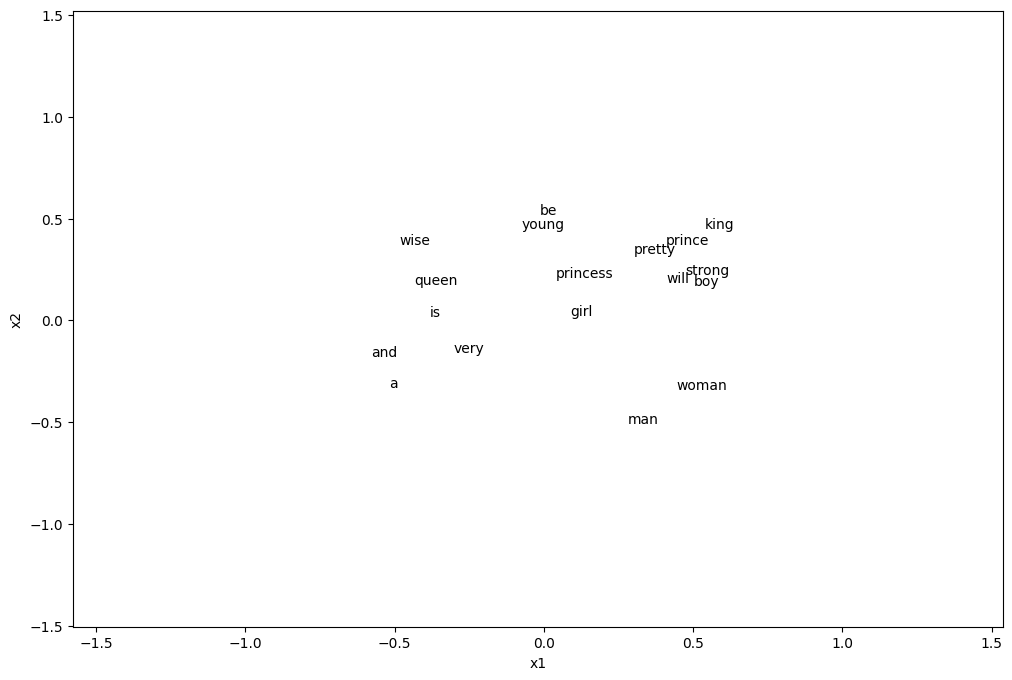

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
#한글 폰트 사용
# from matplotlib import font_manager
# import matplotlib
# font_path = "C:/Windows/Fonts/H2GTRM.TTF"                       #폰트 경로
# font_name = font_manager.FontProperties(fname=font_path).get_name()  #폰트 이름 얻어오기
# matplotlib.rc('font', family=font_name)                                 #font 지정
# matplotlib.rcParams['axes.unicode_minus'] = False               #한글사용시 마이너스 사인 깨짐 방지

fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()